## 365 Data Science Course - Time Series Analysis using Python

> Sincere thanks to the 365 Data Science team for providing 1 month free subscription 
to encorage people to stay at home and improve their skills during the tough times of COVID-19 pandemic
[course link](https://365datascience.teachable.com/courses/666338/)


### Introduction to TS in Python

---

For analyzing TS data effectively, **all time periods must be EQUAL and CLEARLY DEFINED, thus freq should be CONSTANT**

- Patterns observed in TS are expected to persist in the future

- TS data is usually time dependent, that means that the values for every period are affected by outside factors and by the values of past periods

- TS data suffers from **seasonality**. Rain, temp vary depending on time of day and season of the year.. Its a repeating cycle, so we can account for these changes while making predictions


Examples:

1. Weather forecast
2. Finance 

#### Common Notations

X = value at each time period
T = entire period
t = a single period

#### Peculiarities of TS data

In TS analysis intevals bw 2 data pts should be identical

But often, in real world there is missing data

In TS handling of missing data is complicated, as values bw consecutive periods usually affect each other

---

Also in some cases we want to change the freq

For eg, from daily we might want to do a monthly analysis - so we need to aggregate the data in some manner

If we want to reach a more granular level from a broad level, it becomes much mor complex.. now we will need some way to impute the values

---

Unlike regular data, TS data requires chronological order. From ML perspective that means we cannot simply shuffle the data into training and test sets

We must pick a cut off pt.. period before - train, period after - test



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# import the data

raw_csv_data = pd.read_csv('./data/Index2018.csv')

df_comp = raw_csv_data.copy()

In [3]:
df_comp.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


#### Data DESC

Date is used as the index here

The next 4 cols represent closing prices for 4 market indices

- S&P 500 (USA)
- DAX 30 (Germany)
- FTSE 100 (London)
- NIKKEI 225 (Japan)

Each Market Index is a portfolio of the most traded public companies on the resp stock exchange markets

For eg S&P 500 measures stability of the US stock exchange for 500 companies included in this particular portfolio



In [4]:
df_comp.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


Values for dax and ftse are somewhat similar. max value of spx is less than min value of ftse and nikkei. So dax is lower. nikkei is generally higher than the other 3

In [5]:
# check missing values
df_comp.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

#### Plotting the data

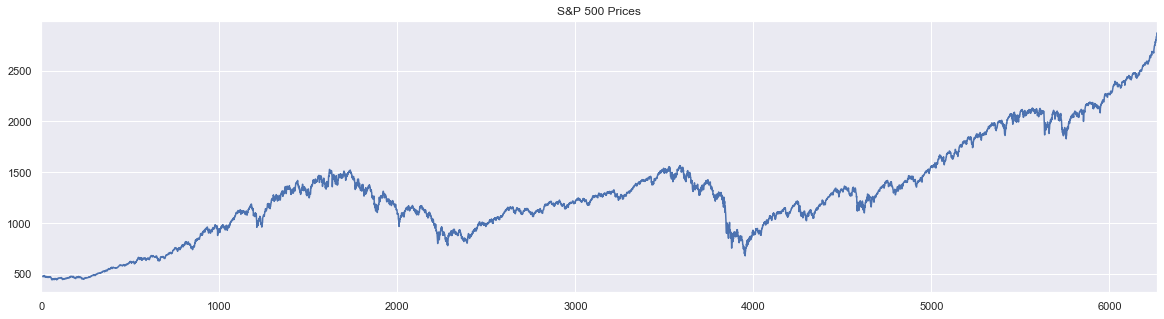

In [6]:
# S&P500

df_comp['spx'].plot(figsize=(20, 5), title='S&P 500 Prices');

The x axis is not proper for now as it is not showing the dates

- The price fluctuates - there are periods of booming growth followed by sharp falls

- The 1st 2 peaks followed by period of turbulence represent dot com and the housing market bubble



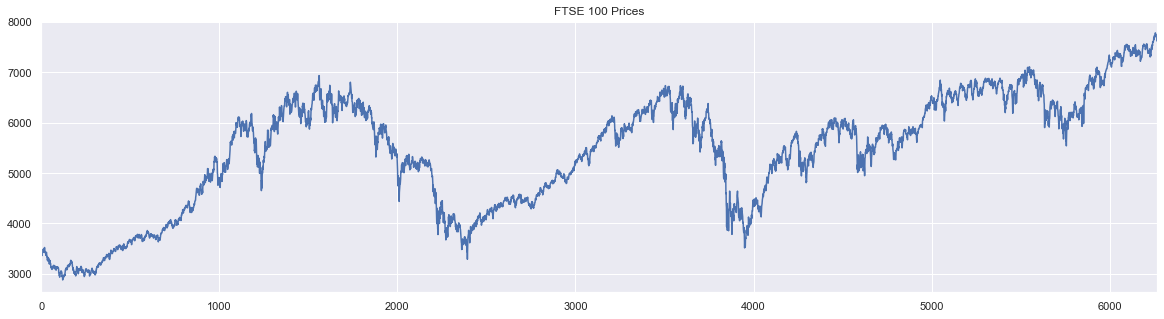

In [7]:
# FTSE

df_comp['ftse'].plot(figsize=(20, 5), title='FTSE 100 Prices');

The above 2 plots are mostly similar

This can be explained by the parallel of the UK and US stock exchange markets



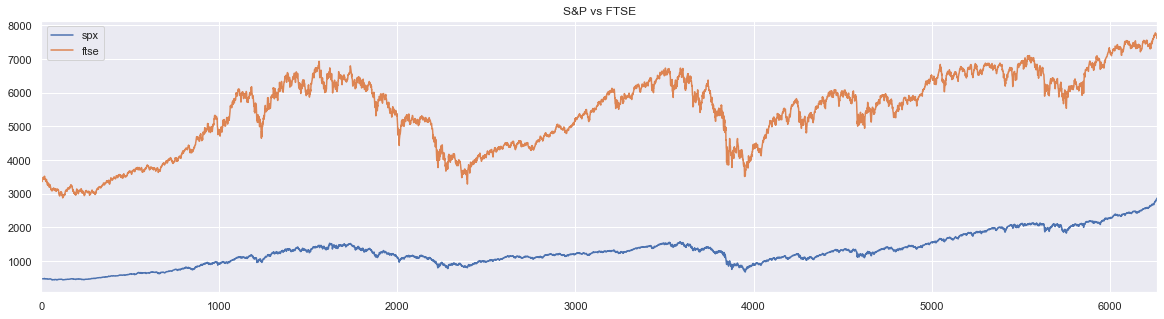

In [8]:
## compare the 2 plots
df_comp['spx'].plot(figsize=(20, 5), legend=True);
df_comp['ftse'].plot(figsize=(20, 5), legend=True);
plt.title('S&P vs FTSE');

Notice how the FTSE values are much higher in magnitude

Also it looks like the s&p values might be more stable, but this is misleading as it looks that way because of the vast diff in magnitude

#### The Quantile-Quantile (QQ) Plot

This plot is used to determine whether a dataset is distributed in a certain way

Unless otherwise specified this plot shows how the data fits a **Normal Dist**




In [9]:
import scipy.stats
import pylab

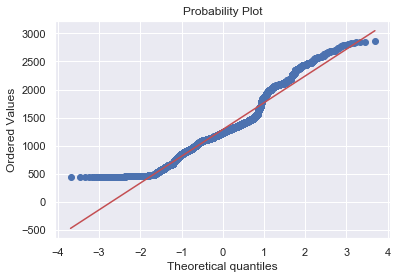

In [10]:
scipy.stats.probplot(x=df_comp['spx'], plot=pylab)
pylab.show();

How the QQ plot works is:

1. Takes all the values a variable can take and arranges them in order
2. The Y axis represents the price.. lowest -> highest
3. X axis represents the theoretical quantiles - how many std devs away from the mean these values are
4. The red diagonal represents what the data pts should follow if they were normally distributed
    - here it is not the case, we have more values around the 500 mark than we should
    - so the data is NOT normally distributed
    - so we cant simply use stats models for ND

### Creating a Time Series Object in Python

---

First lets transfor the date column to the proper date type

In [11]:
df_comp.dtypes

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object

In [12]:
df_comp.describe(include='all')

,date,spx,dax,ftse,nikkei
count,6269,6269.000000,6269.000000,6269.000000,6269.000000
unique,6269,NaN,NaN,NaN,NaN
top,25/09/2012,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,1288.127542,6080.063363,5422.713545,14597.055700
std,NaN,487.586473,2754.361032,1145.572428,4043.122953
min,NaN,438.920000,1911.700000,2876.600000,7054.980000
25%,NaN,990.671905,4069.350000,4486.100000,10709.290000
50%,NaN,1233.420000,5773.340000,5662.430000,15028.170000
75%,NaN,1459.987747,7443.070000,6304.250000,17860.470000


**Note** the top value returned by the describe method for date here is completelt arbitrary!

For Python, all the values in date col are 1s as they hold values which are not 0

Any single date holds the top value

In [13]:
## convert date col to datetime
df_comp['date'] = pd.to_datetime(df_comp['date'], dayfirst=True)

In [14]:
df_comp.head()

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.90,2224.95,3445.98,18124.01
1,1994-01-10,475.27,2225.00,3440.58,18443.44
2,1994-01-11,474.13,2228.10,3413.77,18485.25
3,1994-01-12,474.17,2182.06,3372.02,18793.88
4,1994-01-13,472.47,2142.37,3360.01,18577.26


In [15]:
df_comp['date'].describe()

count                    6269
unique                   6269
top       1999-08-23 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

Our data ranges from 7th Jan 1994 till 29th Jan 2018

We can now use the date as an index in our df as all the values are unique

We have a;rady seen that for our data to be in the proper time series format, each value should corr to a time period

Also we might want to query for specific chunks of data bw 2 concrete dates, for eg: analyzing the great recession data (before and after Sep 15 2008)

Our data is at daily level

In [16]:
df_comp.set_index('date', inplace=True)
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


Once we use the date as an index it is not like any other column that we can simply edit

So before using a col as index it is good practice to check that all the values are correct

#### Setting the frequency

We can do this using the `asfreq` method

The first argument specifies the period

- h: data is hourly
- w: weekly
- d: daily
- m: monthly
- a: anually 

In [17]:
df_comp=df_comp.asfreq(freq='d')
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,NaN,NaN,NaN,NaN
1994-01-09,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


The fact that we have generated these missing values is a sign that we have set the period properly

Another peculiarity of our data is that it represents closing prices of financial indices and these can only be recorded in working days
So we are not interested in holidays or weekends

The dates with missing values above: `1994-01-08` and `1994-01-09` are Sat and Sun and we do not require them

Fortunaltely the `asfreq` func also accepts 'b' as **business days only**

In [18]:
df_comp=df_comp.asfreq(freq='b')
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [19]:
### are there any missing values still?
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

#### Handling missing values

Are all these 8 na values same for each column?

In [20]:
df_comp.loc[df_comp['spx'].isna()]

,spx,dax,ftse,nikkei
date,,,,
2008-01-01,NaN,NaN,NaN,NaN
2009-01-01,NaN,NaN,NaN,NaN
2010-01-01,NaN,NaN,NaN,NaN
2013-01-01,NaN,NaN,NaN,NaN
2014-01-01,NaN,NaN,NaN,NaN
2015-01-01,NaN,NaN,NaN,NaN
2016-01-01,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN


All these values are for 1st Jan!

One of the easiest way to fill missing values is using `fillna()`

##### Fillna() options

1. Front filling: assigns value of the prev period
2. Back filling: assigns value of the next period
3. Assigning the same value to all NA time period (maybe assign avg value to all the missing values) - **Usually filling missing values with mean is a bad idea in TS as there are underlying time variant patterns in the data 

In [21]:
# front-fill s&p missing vals
df_comp['spx'] = df_comp['spx'].fillna(method='ffill')

In [22]:
df_comp.isna().sum()

spx       0
dax       8
ftse      8
nikkei    8
dtype: int64

In [23]:
# back fill the ftse values
df_comp['ftse'] = df_comp['ftse'].fillna(method='bfill')
df_comp.isna().sum()

spx       0
dax       8
ftse      0
nikkei    8
dtype: int64

In [24]:
# avg values to fill dax
df_comp['dax'] = df_comp['dax'].fillna(value=df_comp['dax'].mean())
df_comp.isna().sum()

spx       0
dax       0
ftse      0
nikkei    8
dtype: int64

In [25]:
# front-filling nikkei vals
df_comp['nikkei'] = df_comp['nikkei'].fillna(method='ffill')
df_comp.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In this tutorial we will only analyze the S&P 500 values and not the other 3 so we delete them

In [26]:
df_comp['market_value'] = df_comp['spx']

In [27]:
del df_comp['spx'], df_comp['ftse'], df_comp['nikkei'], df_comp['dax']

In [28]:
df_comp.describe()

,market_value
count,6277.000000
mean,1288.642547
std,487.868210
min,438.920000
25%,992.715221
50%,1233.761241
75%,1460.250000
max,2872.867839


#### Splitting the data

We cant shuffle the data in TS analysis like in other ML approaches as here the chronological order is important

Training set: from beginning to cut-off pt
Test set: cut-off till end

We will use an 80-20 split

In [29]:
size = int(0.8 * len(df_comp))

print (size)

5021


In [30]:
## create training set
df = df_comp.iloc[:size]
df_test = df_comp.iloc[size:]

print (df.shape, df_test.shape, df_comp.shape)

(5021, 1) (1256, 1) (6277, 1)


In [31]:
df.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [32]:
df_test.head()

,market_value
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


- since the tr data ends on 5th apr 2013 and test data starts on 8th apr 2013, there is no overlap

### Working with TS in Python

---

#### White Noise

- White Noise is a special type of TS where the data does not follow a pattern

We cannot predict white noise as it does not follow any pattrens

Conditions for series to be white noise:

1. Constant mean
2. Constant variance
3. no autocorrelation in any period

Autocorr measures how corr a series is with past versions of itself

> Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It is the same as calculating the correlation between two different time series, except autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. 

$autocorr = corr(x_t, x_{t-k})$

> NO autocorr means there is NO clear relationship bw past and present values in a TS - that is why it is noise

So white noise is like a seq of random data, where every value has a time period attached to it, so there is no way to predict the trend

In Financial modeling its imp to distinguish white noise data from regular TS data

One way to do this is by comparing the plots by generating white noise data

In [33]:
### generate white noise data - sample from Normal dist with mean and std equal to that of the s&p data

wn = np.random.normal(loc=df['market_value'].mean(), scale=df['market_value'].std(), size=len(df))

wn.shape

(5021,)

In [34]:
### add wn as a new col
df['wn'] = wn

C:\Users\shaun\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
df.head()

,market_value,wn
date,,
1994-01-07,469.90,1309.112163
1994-01-10,475.27,1121.760872
1994-01-11,474.13,1106.285235
1994-01-12,474.17,1502.427078
1994-01-13,472.47,1128.918019


In [36]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1093.062821
std,292.559287,294.631536
min,438.920000,119.809438
25%,914.620000,892.890797
50%,1144.650000,1092.249667
75%,1316.280729,1294.983216
max,1570.252238,2224.609391


**NOTE** - The mean of the s&p and white moise are quite similar, this is because the wn is noramlly dist around the mean of the s&p, but since each one is generated indv the avg does not have to be the same

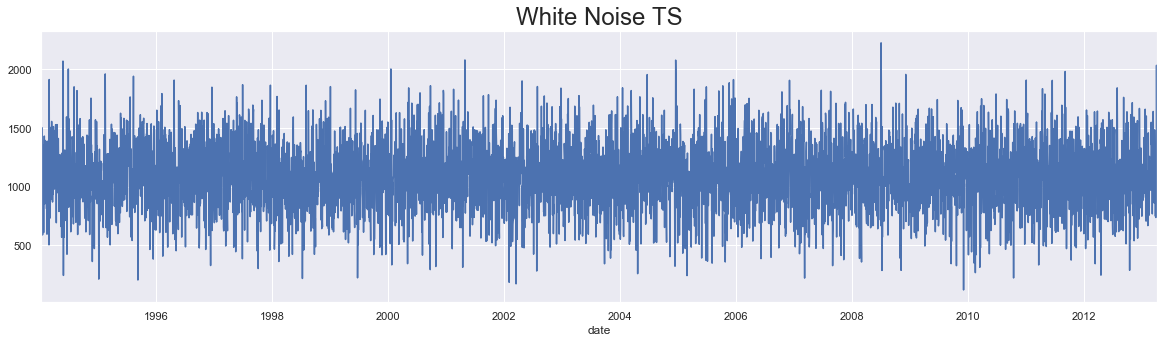

In [37]:
df['wn'].plot(figsize=(20, 5));
plt.title('White Noise TS', size=24)
plt.show();

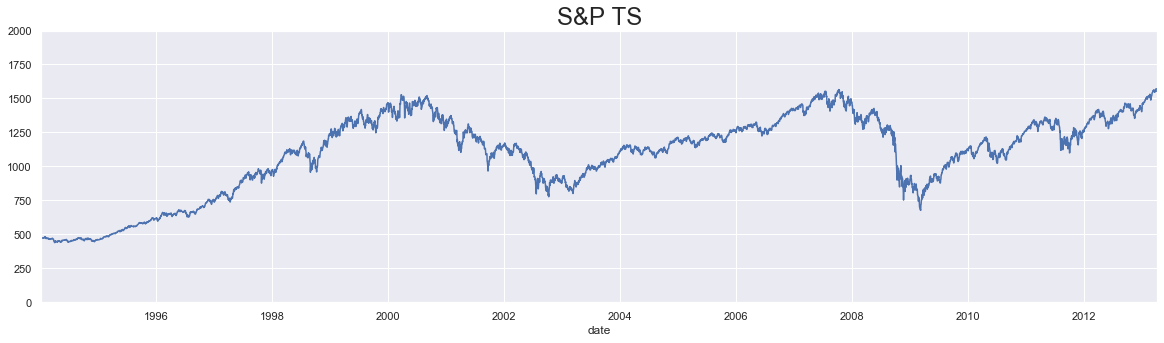

In [38]:
df['market_value'].plot(figsize=(20, 5));
plt.title('S&P TS', size=24)
plt.ylim(0,2000)
plt.show();

#### Random Walk

- A RW is a special type of TS where values tend to persist over time and the diff bw periods are simply white noise

$P_{t} = prices$

$\varepsilon_{t} = residuals$

An eg of a RW is any process for which:

$P_{t} = P_{t-1} + \varepsilon_{t}$

Now since the residual is WN it is arbitrary and cannot be predicted

So the best we can do is for today we estimate the same price as yday, so we can really predict with great accuracy

In [39]:
### load random walk data
rw = pd.read_csv('./data/RandWalk.csv')

rw.head()

,date,price
0,07/01/1994,1122.139662
1,08/01/1994,1135.238562
2,09/01/1994,1109.897831
3,10/01/1994,1080.347860
4,11/01/1994,1082.095245


In [40]:
### change date col to datetime format
rw['date'] = pd.to_datetime(rw['date'], dayfirst=True)
rw.set_index('date', inplace=True)

### set freq to business days
rw = rw.asfreq('b')

In [41]:
rw.head()

,price
date,
1994-01-07,1122.139662
1994-01-10,1080.347860
1994-01-11,1082.095245
1994-01-12,1083.639265
1994-01-13,1067.146255


In [42]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [43]:
### add the RW price to our main df
df['rw'] = rw['price']

df.head()

C:\Users\shaun\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,market_value,wn,rw
date,,,
1994-01-07,469.90,1309.112163,1122.139662
1994-01-10,475.27,1121.760872,1080.347860
1994-01-11,474.13,1106.285235,1082.095245
1994-01-12,474.17,1502.427078,1083.639265
1994-01-13,472.47,1128.918019,1067.146255


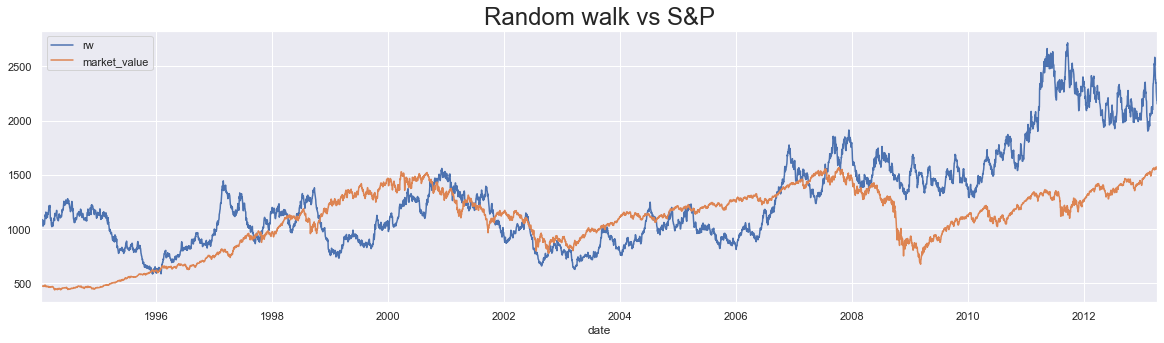

In [44]:
### plot the rw data
df['rw'].plot(figsize=(20,5), legend=True)
df['market_value'].plot(figsize=(20, 5), legend=True)
plt.title('Random walk vs S&P', size=24)
plt.show();

- the RW data differs a lot from WN
- In fact it looks similar to the S&P plot
    - both have small variations bw consecutive time periods
    - both have cyclic inc and dec in short periods of time
    
In finance there is a term called **Market efficiency**

- it measures the level of difficulty in forecasting correct future values
- if a TS resembels a RW the prices cant be predicted with great accuracy
- Conversely, if future prices **can** be predicted with great accuracy, then there are **Arbitrage Opportumities**

##### Arbitrage

when investors manage to buy and sell commodities and make a safe profit, while the price adjusts

> If such opportunities exist in the market, investors take advantage, which eventually leads to a price that matches the expected one. As a result prices adjust accordingly and that is why we usually expect most markets to be more or less efficient 

> WN and RW sound quite similar but from the plots we realized that they are quite different



#### Stationarity

- taking consecutive samples of data with the same size should have identical covariances, regardless of the starting pt
    - this characteristic of the data is also called **weak form stationarity** or **covariance stationarity**

<img src = './img/diag1.png'>

- Covariance is a measure of how much two random variables vary together. It’s similar to variance, but where variance tells you how a single variable varies, co variance tells you how two variables vary together.

- When two stocks tend to move together, they are seen as having a positive covariance; when they move inversely, the covariance is negative.


##### Covariance stationarity assumptions

1. Constant mean
2. Constant variance
3. Consistent cov bw periods at an identical distance from one another

    $cov(x_n, x_{n+k}) = cov(x_m, x_{m+k})$
    
    For eg, Cov(x1, x4) = Cov(x3, x6) : Cov bw the 1st and 4th period is same as the cov bw the 3rd and 6th period as they are 3 intervals apart
    
An example of this is WN:
1. mean is 0
2. variance stays same
3. no autocorr in any period

$autocorr = corr(x_t, x_{t-k})$

But cov is corr times the std deviations

![](https://s3.amazonaws.com/acadgildsite/wordpress_images/Data+Science/Correlation+%2C+Covariance/image8.png)

$cov(x_n, x_{n+k}) = corr(x_m, x_{m+k})\sigma_1\sigma _2=0$

> So WN satisfies all assumptions of a Covariance stationary process


##### Strict stationarity

- samples of identical size would have identical distributions

For any strictly stationary random var X

$(x_t, x_{t+k})\sim Dist(\mu , \sigma ^2)$

$(x_{t+\tau}, x_{t+k+\tau})\sim Dist(\mu , \sigma ^2)$

for any natural no $\tau$

Since this case is v restrictive we rarely observe it in the natural world

> In analytics stationarity means cov stationarity





#### Determining weak form of stationarity

To conduct proper TSA it is vital to understand whether the data follows a stationary or non-stationary process

The **Dickey-Fuller** test is used for this purpose

##### DF Test

Ho (Null Hypothesis) : Assumes Non stationarity OR more specifically the one-lag auto-corr coeff < 1 i.e $ \varphi<1 $

H1 (Alt Hypothesis): $\varphi=1$

When we have computed the etst statistic we compare it to the critical value in the DF table

```
If test stat < critical value: reject the NULL -> data comes from stationary process

else: non stationary; we cant reject NULL
```


In [45]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

In [46]:
sts.adfuller(df['market_value'])

(-1.7369847452352456,
 0.4121645696770613,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

##### Understanding the op:

The first op: -1.7369847452352456 represents the test statistic

Also python provides us with the 1,5 and 10% critical values from the DF table - we might use any of them as levels of significance in our analysis

We can see that the t-stat is greater than each of the cvs - thus, **for all of these levels of significance we do not find sufficient evidence to reject the NULL - i.e data is non-stationary**

The second value: 0.4121645696770613 is the p-value associated with the t-statistic - this suggests that there is 41.216% chance of NOT rejecting the NULL i.e 41.2% chance that NULL is true i.e data is non-stationary

18: refers to the num of lags used in the regression - so there is some auto corr going back 18 periods - we should take this into acc while chosing the model

5002: num of obs used in the analysis - this depends on the num of lags, so the two should add up to the size of the dataset

The last value: 39904.880607487445 estimates the maximised info criteria, provided there is some apparent autocorrr, the lower the values, the easier it is to make predictions for the future


Lets run the same test for WN data:


In [48]:
sts.adfuller(df['wn'])

(-48.93891003291513,
 0.0,
 1,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 70883.03472190206)

WN is stationary process, so p-value should be low (yes)

Since there is no autocorr in WN there should be no lags involved in the regression (yes)

In [49]:
### for the RW
sts.adfuller(df['rw'])

(-1.3286073927689708,
 0.6159849181617388,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

- p value is larger - so there is more than 60% chance that data comes from non stationary process

RW intervals of the same size differs significantly, which goes against the basic condition for stationarity

<img src = './img/diag2.png' width = "700" height = "300">

Also in the diag below in teh first circle the prices are going constantly up and in the 2nd cycle the prices are going up and down, so the cov of 2 such intervals of identical size will be very unlikely to be equal, so we do expect RW to be non-stationary

<img src = './img/diag3.png' width = "700" height = "300">

> Thus the results of the DF test satisfy our expectations